##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 간단한 오디오 인식: 키워드 인식

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼에서는 WAV 형식의 오디오 파일을 사전 처리하고 10개의 다른 단어를 인식하기 위한 기본적인 <a href="https://en.wikipedia.org/wiki/Speech_recognition" class="external">자동 음성 인식</a>(ASR) 모델을 구축하고 훈련하는 방법을 보여줍니다. "down", "go", "left", "no", "right", "stop", "up" 및 "yes"와 같은 명령의 짧은(1초 이하) 오디오 클립이 포함된 [음성 명령 데이터세트](https://www.tensorflow.org/datasets/catalog/speech_commands)(<a href="https://arxiv.org/abs/1804.03209" class="external">Warden, 2018</a>)의 일부를 사용할 것입니다.

실제 음성 및 오디오 인식 <a href="https://ai.googleblog.com/search/label/Speech%20Recognition" class="external">시스템</a>은 복잡합니다. 그러나 [MNIST 데이터세트를 사용한 이미지 분류](../quickstart/beginner.ipynb)와 마찬가지로 이 튜토리얼은 관련된 기술에 대한 기본적인 이해를 제공합니다.

## 설정

필요한 모듈과 종속성을 가져옵니다. 이 튜토리얼에서는 시각화를 위해 <a href="https://seaborn.pydata.org/" class="external">seaborn</a>을 사용할 것입니다.

In [2]:
# Upgrade environment to support TF 2.10 in Colab
!pip install -U --pre tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2022-12-14 22:41:06.811377: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:41:06.811495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:41:06.811506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 미니 음성 명령 데이터세트 가져오기

데이터 로드 시간을 절약하기 위해 더 작은 버전의 음성 명령 데이터세트로 작업할 것입니다. [원본 데이터세트](https://www.tensorflow.org/datasets/catalog/speech_commands)는 35개의 다른 단어를 말하는 사람들의 음성이 <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV(Waveform) 오디오 파일 형식</a>으로 담겨 있는 105,000개 이상의 오디오 파일로 구성됩니다. 이 데이터는 Google에서 수집했으며 CC BY의 허가를 얻어 배포했습니다.

`tf.keras.utils.get_file`을 사용하여 작은 음성 명령 데이터세트가 포함된 `mini_speech_commands.zip` 파일을 다운로드하고 압축을 풉니다.

In [4]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

     8192/182082353 [..............................] - ETA: 0s

  4538368/182082353 [..............................] - ETA: 1s

 13770752/182082353 [=>............................] - ETA: 1s

 26869760/182082353 [===>..........................] - ETA: 0s

 40075264/182082353 [=====>........................] - ETA: 0s

 50528256/182082353 [=======>......................] - ETA: 0s

 62636032/182082353 [=========>....................] - ETA: 0s

 73859072/182082353 [===========>..................] - ETA: 0s

 86196224/182082353 [=============>................] - ETA: 0s

 97935360/182082353 [===============>..............] - ETA: 0s

109953024/182082353 [=================>............] - ETA: 0s

118882304/182082353 [==================>...........] - ETA: 0s

130752512/182082353 [====================>.........] - ETA: 0s

143990784/182082353 [======================>.......] - ETA: 0s

157458432/182082353 [========================>.....] - ETA: 0s

167780352/182082353 [==========================>...] - ETA: 0s

182082353/182082353 [==============================] - 1s 0us/step


데이터세트의 오디오 클립은 각 음성 명령에 해당하는 8개의 폴더(`no`, `yes`, `down`, `go`, `left`, `up`, `right` 및 `stop`)에 저장됩니다.

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'left' 'stop' 'up' 'no' 'go' 'down' 'yes']


이러한 방식으로 디렉터리를 나누면 `keras.utils.audio_dataset_from_directory`를 사용하여 데이터를 쉽게 로드할 수 있습니다.

오디오 클립은 16kHz에서 1초 이하입니다. `output_sequence_length=16000`은 짧은 클립을 정확히 1초로 채우고 긴 클립은 잘라 쉽게 일괄 처리할 수 있습니다.

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.



label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


이제 데이터세트에 오디오 클립과 정수 레이블의 배치가 포함됩니다. 오디오 클립의 형상은 `(batch, samples, channels)`입니다. 

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

이 데이터세트에는 단일 채널 오디오만 포함되어 있으므로 `tf.squeeze` 함수를 사용하여 추가 축을 삭제합니다.

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

`utils.audio_dataset_from_directory` 함수는 최대 두 개의 분할만 반환합니다. 테스트세트를 유효성 검증 세트와 별도로 유지하는 것이 좋습니다. 이상적으로는 별도의 디렉터리에 보관하지만 이 경우 `Dataset.shard`를 사용하여 유효성 검사 세트를 두 부분으로 나눌 수 있습니다. **어떤** 샤드던 반복하면 **모든** 데이터가 로드되고 일부만 유지됩니다. 

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


몇 가지 오디오 파형을 플롯해 보겠습니다.

In [11]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

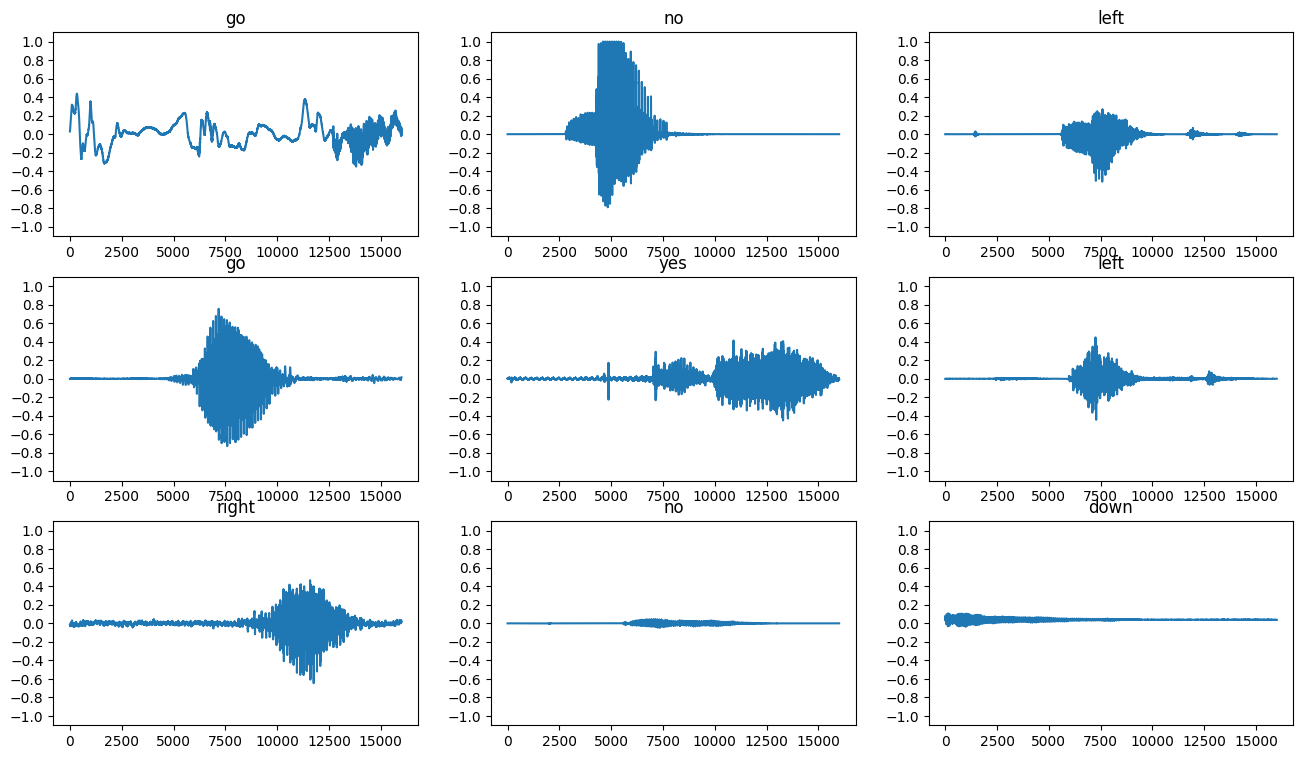

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

## 파형을 스펙트로그램으로 변환하기

데이터세트의 파형은 시간 영역에서 표시됩니다. 다음으로, 시간-영역 신호의 파형을 시간-주파수-영역 신호로 변환합니다. 이를 위해 <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">STFT(short-time Fourier transform)</a>를 계산하여 시간에 따른 주파수 변화를 보여주고 2D 이미지로 나타낼 수 있는 <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">스펙트로그램</a>으로 파형을 변환합니다. 스펙트로그램 이미지를 신경망에 공급하여 모델을 훈련시킵니다.

퓨리에 변환(`tf.signal.fft`)은 신호를 성분 주파수로 변환하지만 모든 시간 정보는 손실됩니다. 이에 비해 STFT(`tf.signal.stft`)는 신호를 시간 창으로 분할하고 각 창에서 퓨리에 변환을 실행하여 일부 시간 정보를 보존하고 표준 콘볼루션을 실행할 수 있는 2D 텐서를 반환합니다.

파형을 스펙트로그램으로 변환하기 위한 유틸리티 함수를 생성합니다.

- 파형은 길이가 같아야 스펙트로그램으로 변환할 때 결과가 비슷한 차원을 갖게 됩니다. 이를 위해 1초보다 짧은 오디오 클립을 단순히 0으로 채울 수 있습니다(`tf.zeros` 사용).
- `tf.signal.stft`를 호출할 때 생성된 스펙트로그램 "이미지"가 거의 정사각형이 되도록 `frame_length` 및 `frame_step` 매개변수를 선택합니다. STFT 매개변수 선택에 대한 자세한 내용은 오디오 신호 처리 및 STFT에 대한 <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">이 Coursera 비디오</a>를 참조하세요.
- STFT는 크기와 위상을 나타내는 복소수 배열을 생성합니다. 그러나 이 튜토리얼에서는 `tf.abs`의 출력에 `tf.signal.stft`를 적용하여 유도할 수 있는 크기만 사용합니다.

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

다음으로, 데이터 탐색을 시작합니다. 한 예의 텐서화된 파형과 해당 스펙트로그램의 형상을 출력하고 원본 오디오를 재생합니다.

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


이제 스펙트로그램을 표시하는 함수를 정의합니다.

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

시간에 따른 예제의 파형과 해당 스펙트로그램(시간에 따른 주파수)을 플롯합니다.

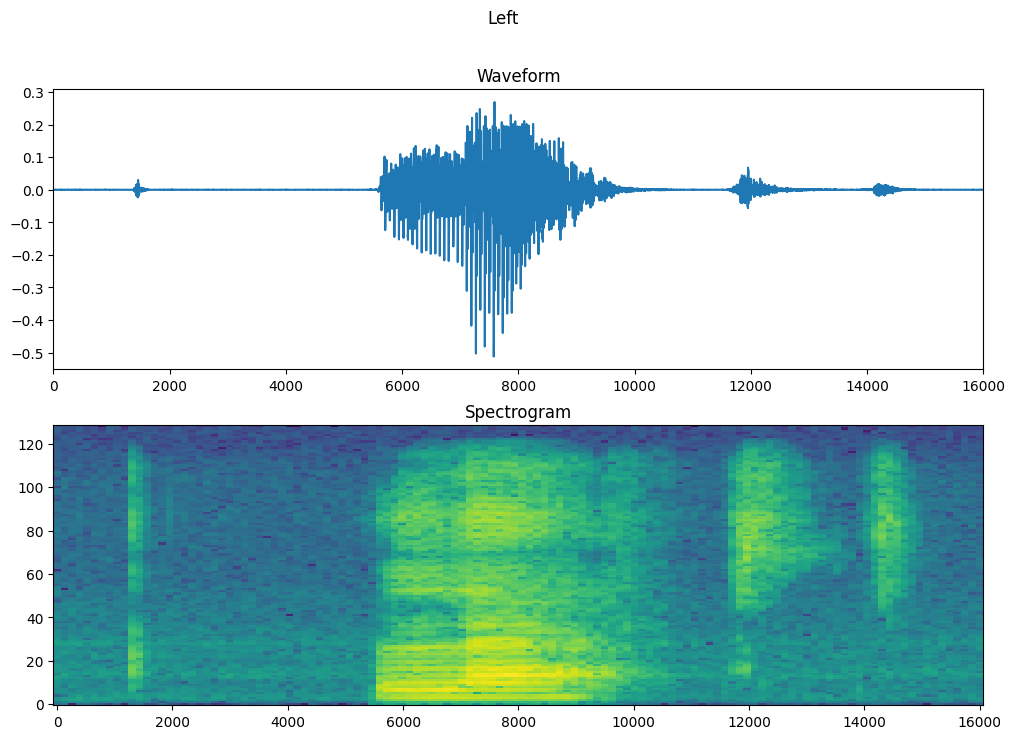

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

이제 오디오 데이터세트에서 스펙트로그램 데이터세트를 생성합니다.

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


데이터세트의 다양한 예에 대한 스펙트로그램을 살펴봅니다.

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

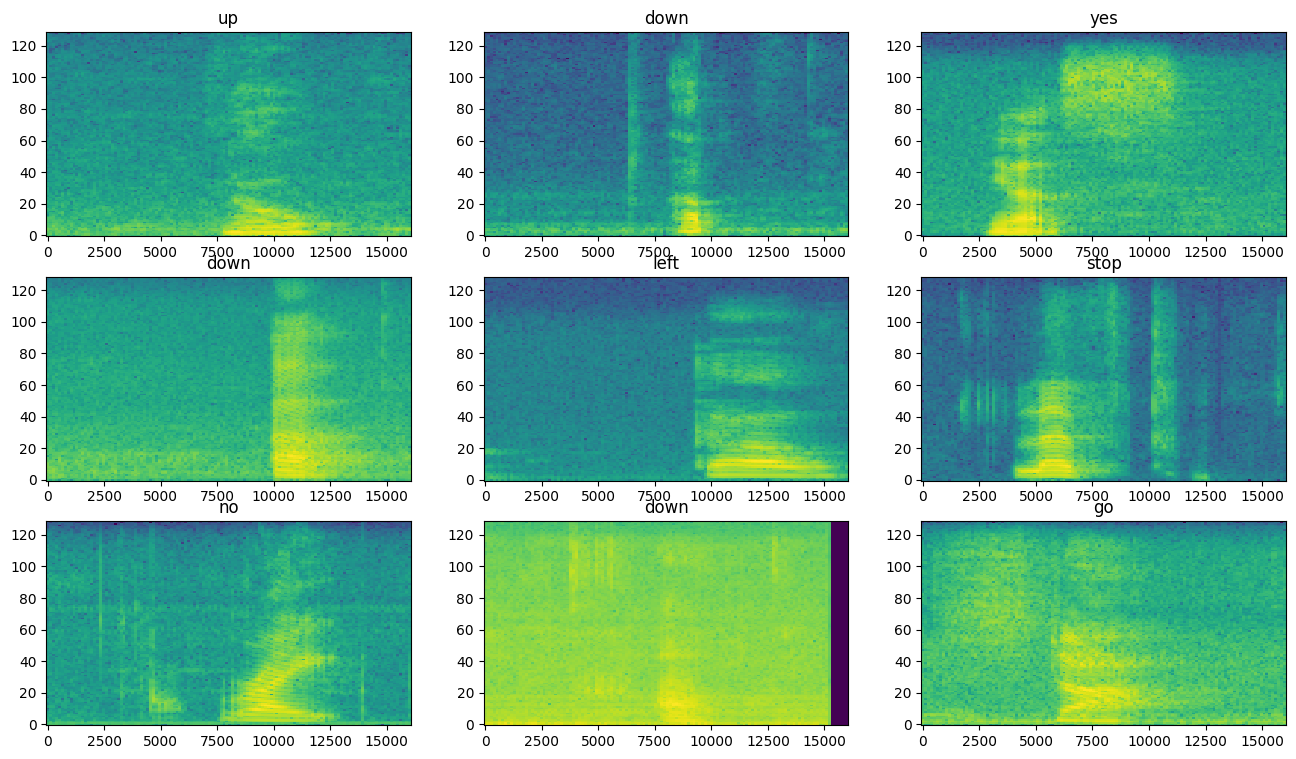

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

## 모델 빌드 및 훈련하기

모델을 훈련하는 동안 읽기 지연 시간을 줄이기 위해 `Dataset.cache` 및 `Dataset.prefetch` 작업을 추가합니다.

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

이 모델의 경우, 오디오 파일을 스펙트로그램 이미지로 변환했으므로 간단한 콘볼루션 신경망(CNN)을 사용합니다.

`tf.keras.Sequential` 모델은 다음과 같은 Keras 전처리 레이어를 사용합니다.

- `tf.keras.layers.Resizing`: 모델이 더 빨리 학습할 수 있도록 입력을 다운샘플링합니다.
- `tf.keras.layers.Normalization`: 평균과 표준 편차를 기반으로 이미지의 각 픽셀을 정규화합니다.

`Normalization` 레이어의 경우, 집계 통계(즉, 평균 및 표준 편차)를 계산하기 위해 먼저 훈련 데이터에 대해 해당 `adapt` 메서드를 호출해야 합니다.

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resizing (Resizing)         (None, 32, 32, 1)         0         


 normalization (Normalizatio  (None, 32, 32, 1)        3         


 n)                                                              


 conv2d (Conv2D)             (None, 30, 30, 32)        320       


 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     


 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         


 )                                                               


 dropout (Dropout)           (None, 14, 14, 64)        0         


 flatten (Flatten)           (None, 12544)             0         


 dense (Dense)               (None, 128)               1605760   


 dropout_1 (Dropout)         (None, 128)               0         


 dense_1 (Dense)             (None, 8)                 1032      


Total params: 1,625,611


Trainable params: 1,625,608


Non-trainable params: 3


_________________________________________________________________


Adam 옵티마이저와 교차 엔트로피 손실을 사용하여 Keras 모델을 구성합니다.

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

데모 목적으로 10번의 epoch에 걸쳐 모델을 훈련합니다.

In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2022-12-14 22:41:22.155393: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/100 [..............................] - ETA: 5:46 - loss: 2.0825 - accuracy: 0.1094

  9/100 [=>............................] - ETA: 0s - loss: 2.1125 - accuracy: 0.1528  

 18/100 [====>.........................] - ETA: 0s - loss: 2.0678 - accuracy: 0.1953

 27/100 [=======>......................] - ETA: 0s - loss: 2.0292 - accuracy: 0.2297

 36/100 [=========>....................] - ETA: 0s - loss: 1.9863 - accuracy: 0.2543

 45/100 [============>.................] - ETA: 0s - loss: 1.9421 - accuracy: 0.2785

 54/100 [===============>..............] - ETA: 0s - loss: 1.9123 - accuracy: 0.3035

 63/100 [=================>............] - ETA: 0s - loss: 1.8853 - accuracy: 0.3140

 72/100 [====================>.........] - ETA: 0s - loss: 1.8539 - accuracy: 0.3273

 81/100 [=======================>......] - ETA: 0s - loss: 1.8150 - accuracy: 0.3441

 89/100 [=========================>....] - ETA: 0s - loss: 1.7855 - accuracy: 0.3550

 97/100 [============================>.] - ETA: 0s - loss: 1.7687 - accuracy: 0.3647

100/100 [==============================] - 5s 11ms/step - loss: 1.7587 - accuracy: 0.3675 - val_loss: 1.3531 - val_accuracy: 0.5964


Epoch 2/10


  1/100 [..............................] - ETA: 0s - loss: 1.4316 - accuracy: 0.4219

 10/100 [==>...........................] - ETA: 0s - loss: 1.3595 - accuracy: 0.4766

 19/100 [====>.........................] - ETA: 0s - loss: 1.3272 - accuracy: 0.5140

 28/100 [=======>......................] - ETA: 0s - loss: 1.3164 - accuracy: 0.5212

 37/100 [==========>...................] - ETA: 0s - loss: 1.3074 - accuracy: 0.5304

 46/100 [============>.................] - ETA: 0s - loss: 1.2920 - accuracy: 0.5394

 54/100 [===============>..............] - ETA: 0s - loss: 1.2761 - accuracy: 0.5457

 63/100 [=================>............] - ETA: 0s - loss: 1.2531 - accuracy: 0.5508

 72/100 [====================>.........] - ETA: 0s - loss: 1.2461 - accuracy: 0.5543

 81/100 [=======================>......] - ETA: 0s - loss: 1.2396 - accuracy: 0.5544

 90/100 [==========================>...] - ETA: 0s - loss: 1.2269 - accuracy: 0.5618

 99/100 [============================>.] - ETA: 0s - loss: 1.2141 - accuracy: 0.5660

100/100 [==============================] - 1s 7ms/step - loss: 1.2136 - accuracy: 0.5658 - val_loss: 0.9540 - val_accuracy: 0.7253


Epoch 3/10


  1/100 [..............................] - ETA: 0s - loss: 0.9180 - accuracy: 0.6562

 10/100 [==>...........................] - ETA: 0s - loss: 0.8593 - accuracy: 0.7031

 19/100 [====>.........................] - ETA: 0s - loss: 0.9093 - accuracy: 0.6826

 28/100 [=======>......................] - ETA: 0s - loss: 0.8975 - accuracy: 0.6897

 36/100 [=========>....................] - ETA: 0s - loss: 0.9200 - accuracy: 0.6814

 44/100 [============>.................] - ETA: 0s - loss: 0.9350 - accuracy: 0.6744

 52/100 [==============>...............] - ETA: 0s - loss: 0.9384 - accuracy: 0.6689

 61/100 [=================>............] - ETA: 0s - loss: 0.9328 - accuracy: 0.6729

 70/100 [====================>.........] - ETA: 0s - loss: 0.9345 - accuracy: 0.6757

 79/100 [======================>.......] - ETA: 0s - loss: 0.9356 - accuracy: 0.6756

 88/100 [=========================>....] - ETA: 0s - loss: 0.9245 - accuracy: 0.6792

 97/100 [============================>.] - ETA: 0s - loss: 0.9196 - accuracy: 0.6806

100/100 [==============================] - 1s 7ms/step - loss: 0.9184 - accuracy: 0.6803 - val_loss: 0.7514 - val_accuracy: 0.7630


Epoch 4/10


  1/100 [..............................] - ETA: 0s - loss: 0.7977 - accuracy: 0.7344

 10/100 [==>...........................] - ETA: 0s - loss: 0.7929 - accuracy: 0.7250

 19/100 [====>.........................] - ETA: 0s - loss: 0.7789 - accuracy: 0.7253

 28/100 [=======>......................] - ETA: 0s - loss: 0.7789 - accuracy: 0.7182

 37/100 [==========>...................] - ETA: 0s - loss: 0.7650 - accuracy: 0.7255

 46/100 [============>.................] - ETA: 0s - loss: 0.7694 - accuracy: 0.7303

 55/100 [===============>..............] - ETA: 0s - loss: 0.7702 - accuracy: 0.7341

 64/100 [==================>...........] - ETA: 0s - loss: 0.7647 - accuracy: 0.7358

 73/100 [====================>.........] - ETA: 0s - loss: 0.7533 - accuracy: 0.7378

 82/100 [=======================>......] - ETA: 0s - loss: 0.7481 - accuracy: 0.7393

 91/100 [==========================>...] - ETA: 0s - loss: 0.7502 - accuracy: 0.7399

100/100 [==============================] - ETA: 0s - loss: 0.7535 - accuracy: 0.7386

100/100 [==============================] - 1s 7ms/step - loss: 0.7535 - accuracy: 0.7386 - val_loss: 0.6664 - val_accuracy: 0.7956


Epoch 5/10


  1/100 [..............................] - ETA: 0s - loss: 0.9571 - accuracy: 0.5781

 10/100 [==>...........................] - ETA: 0s - loss: 0.6693 - accuracy: 0.7609

 19/100 [====>.........................] - ETA: 0s - loss: 0.6511 - accuracy: 0.7747

 28/100 [=======>......................] - ETA: 0s - loss: 0.6447 - accuracy: 0.7801

 37/100 [==========>...................] - ETA: 0s - loss: 0.6341 - accuracy: 0.7863

 46/100 [============>.................] - ETA: 0s - loss: 0.6443 - accuracy: 0.7762

 55/100 [===============>..............] - ETA: 0s - loss: 0.6473 - accuracy: 0.7747

 64/100 [==================>...........] - ETA: 0s - loss: 0.6403 - accuracy: 0.7759

 73/100 [====================>.........] - ETA: 0s - loss: 0.6340 - accuracy: 0.7765

 82/100 [=======================>......] - ETA: 0s - loss: 0.6293 - accuracy: 0.7793

 91/100 [==========================>...] - ETA: 0s - loss: 0.6280 - accuracy: 0.7806

100/100 [==============================] - ETA: 0s - loss: 0.6313 - accuracy: 0.7794

100/100 [==============================] - 1s 7ms/step - loss: 0.6313 - accuracy: 0.7794 - val_loss: 0.6036 - val_accuracy: 0.8138


Epoch 6/10


  1/100 [..............................] - ETA: 0s - loss: 0.5988 - accuracy: 0.8125

 10/100 [==>...........................] - ETA: 0s - loss: 0.6138 - accuracy: 0.7828

 19/100 [====>.........................] - ETA: 0s - loss: 0.5962 - accuracy: 0.7928

 28/100 [=======>......................] - ETA: 0s - loss: 0.5991 - accuracy: 0.7879

 37/100 [==========>...................] - ETA: 0s - loss: 0.5911 - accuracy: 0.7931

 46/100 [============>.................] - ETA: 0s - loss: 0.5829 - accuracy: 0.7972

 55/100 [===============>..............] - ETA: 0s - loss: 0.5745 - accuracy: 0.7977

 64/100 [==================>...........] - ETA: 0s - loss: 0.5716 - accuracy: 0.8013

 73/100 [====================>.........] - ETA: 0s - loss: 0.5676 - accuracy: 0.8037

 82/100 [=======================>......] - ETA: 0s - loss: 0.5642 - accuracy: 0.8060

 90/100 [==========================>...] - ETA: 0s - loss: 0.5622 - accuracy: 0.8062

 99/100 [============================>.] - ETA: 0s - loss: 0.5556 - accuracy: 0.8084

100/100 [==============================] - 1s 7ms/step - loss: 0.5545 - accuracy: 0.8091 - val_loss: 0.5451 - val_accuracy: 0.8333


Epoch 7/10


  1/100 [..............................] - ETA: 0s - loss: 0.3969 - accuracy: 0.8594

 10/100 [==>...........................] - ETA: 0s - loss: 0.4843 - accuracy: 0.8188

 19/100 [====>.........................] - ETA: 0s - loss: 0.5079 - accuracy: 0.8207

 28/100 [=======>......................] - ETA: 0s - loss: 0.4878 - accuracy: 0.8304

 37/100 [==========>...................] - ETA: 0s - loss: 0.4899 - accuracy: 0.8277

 46/100 [============>.................] - ETA: 0s - loss: 0.4938 - accuracy: 0.8210

 55/100 [===============>..............] - ETA: 0s - loss: 0.4913 - accuracy: 0.8219

 64/100 [==================>...........] - ETA: 0s - loss: 0.4930 - accuracy: 0.8215

 73/100 [====================>.........] - ETA: 0s - loss: 0.4867 - accuracy: 0.8264

 82/100 [=======================>......] - ETA: 0s - loss: 0.4890 - accuracy: 0.8253

 91/100 [==========================>...] - ETA: 0s - loss: 0.4924 - accuracy: 0.8247

100/100 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.8236

100/100 [==============================] - 1s 7ms/step - loss: 0.4948 - accuracy: 0.8236 - val_loss: 0.5296 - val_accuracy: 0.8216


Epoch 8/10


  1/100 [..............................] - ETA: 0s - loss: 0.3080 - accuracy: 0.8750

 10/100 [==>...........................] - ETA: 0s - loss: 0.4089 - accuracy: 0.8719

 19/100 [====>.........................] - ETA: 0s - loss: 0.3974 - accuracy: 0.8643

 28/100 [=======>......................] - ETA: 0s - loss: 0.4078 - accuracy: 0.8516

 37/100 [==========>...................] - ETA: 0s - loss: 0.4262 - accuracy: 0.8476

 46/100 [============>.................] - ETA: 0s - loss: 0.4227 - accuracy: 0.8495

 55/100 [===============>..............] - ETA: 0s - loss: 0.4189 - accuracy: 0.8520

 64/100 [==================>...........] - ETA: 0s - loss: 0.4241 - accuracy: 0.8513

 73/100 [====================>.........] - ETA: 0s - loss: 0.4308 - accuracy: 0.8491

 82/100 [=======================>......] - ETA: 0s - loss: 0.4286 - accuracy: 0.8487

 91/100 [==========================>...] - ETA: 0s - loss: 0.4281 - accuracy: 0.8484

100/100 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.8494

100/100 [==============================] - 1s 7ms/step - loss: 0.4280 - accuracy: 0.8494 - val_loss: 0.5068 - val_accuracy: 0.8398


Epoch 9/10


  1/100 [..............................] - ETA: 0s - loss: 0.4579 - accuracy: 0.8125

 10/100 [==>...........................] - ETA: 0s - loss: 0.4392 - accuracy: 0.8391

 19/100 [====>.........................] - ETA: 0s - loss: 0.4344 - accuracy: 0.8421

 28/100 [=======>......................] - ETA: 0s - loss: 0.4133 - accuracy: 0.8488

 37/100 [==========>...................] - ETA: 0s - loss: 0.4034 - accuracy: 0.8581

 46/100 [============>.................] - ETA: 0s - loss: 0.4074 - accuracy: 0.8560

 55/100 [===============>..............] - ETA: 0s - loss: 0.4139 - accuracy: 0.8560

 64/100 [==================>...........] - ETA: 0s - loss: 0.4051 - accuracy: 0.8601

 73/100 [====================>.........] - ETA: 0s - loss: 0.4060 - accuracy: 0.8594

 82/100 [=======================>......] - ETA: 0s - loss: 0.4063 - accuracy: 0.8596

 91/100 [==========================>...] - ETA: 0s - loss: 0.4027 - accuracy: 0.8597

100/100 [==============================] - ETA: 0s - loss: 0.4031 - accuracy: 0.8586

100/100 [==============================] - 1s 7ms/step - loss: 0.4031 - accuracy: 0.8586 - val_loss: 0.4698 - val_accuracy: 0.8503


Epoch 10/10


  1/100 [..............................] - ETA: 0s - loss: 0.4417 - accuracy: 0.8438

 10/100 [==>...........................] - ETA: 0s - loss: 0.3431 - accuracy: 0.8734

 19/100 [====>.........................] - ETA: 0s - loss: 0.3346 - accuracy: 0.8808

 28/100 [=======>......................] - ETA: 0s - loss: 0.3492 - accuracy: 0.8750

 37/100 [==========>...................] - ETA: 0s - loss: 0.3422 - accuracy: 0.8801

 46/100 [============>.................] - ETA: 0s - loss: 0.3455 - accuracy: 0.8777

 55/100 [===============>..............] - ETA: 0s - loss: 0.3480 - accuracy: 0.8764

 64/100 [==================>...........] - ETA: 0s - loss: 0.3475 - accuracy: 0.8777

 73/100 [====================>.........] - ETA: 0s - loss: 0.3446 - accuracy: 0.8789

 82/100 [=======================>......] - ETA: 0s - loss: 0.3446 - accuracy: 0.8780

 91/100 [==========================>...] - ETA: 0s - loss: 0.3521 - accuracy: 0.8765

100/100 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.8766

100/100 [==============================] - 1s 7ms/step - loss: 0.3533 - accuracy: 0.8766 - val_loss: 0.4793 - val_accuracy: 0.8398


훈련 및 유효성 검증 손실 곡선을 플롯하여 훈련 중에 모델이 어떻게 개선되었는지 확인하겠습니다.

Text(0, 0.5, 'Accuracy [%]')

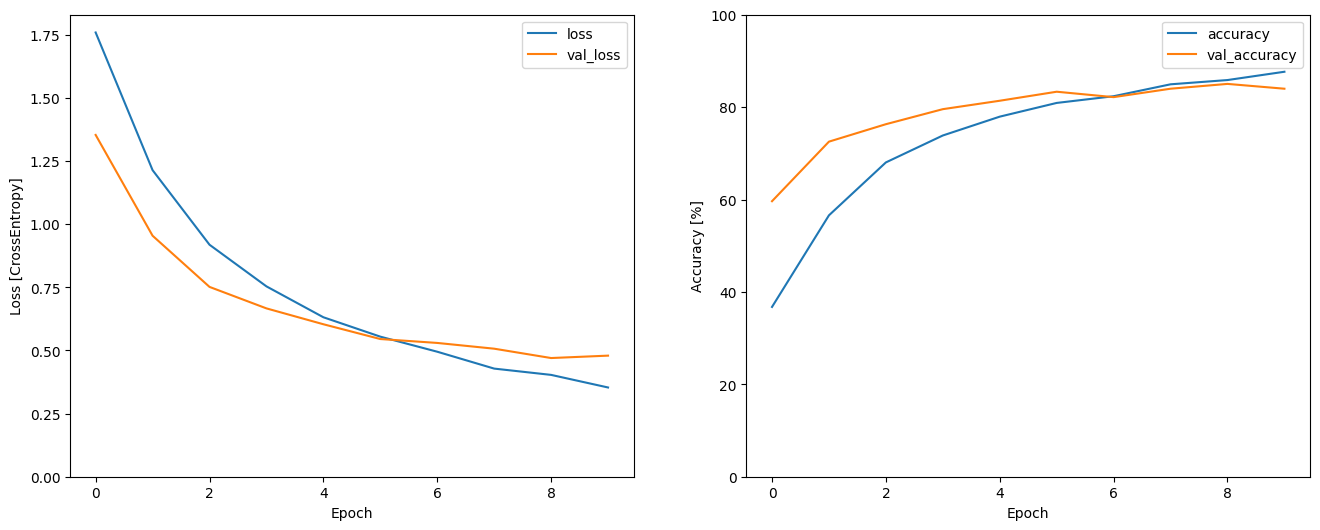

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## 모델 성능 평가하기

테스트세트에서 모델을 실행하고 모델의 성능을 확인합니다.

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

 1/13 [=>............................] - ETA: 2s - loss: 0.6670 - accuracy: 0.7500

 5/13 [==========>...................] - ETA: 0s - loss: 0.5136 - accuracy: 0.8344

13/13 [==============================] - 0s 8ms/step - loss: 0.4793 - accuracy: 0.8486


{'loss': 0.47930723428726196, 'accuracy': 0.848557710647583}

### 혼동 행렬 표시하기

<a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">혼동 행렬</a>을 사용하여 모델이 테스트세트의 각 명령을 얼마나 잘 분류했는지 확인합니다.


In [27]:
y_pred = model.predict(test_spectrogram_ds)

 1/13 [=>............................] - ETA: 1s

13/13 [==============================] - 0s 3ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

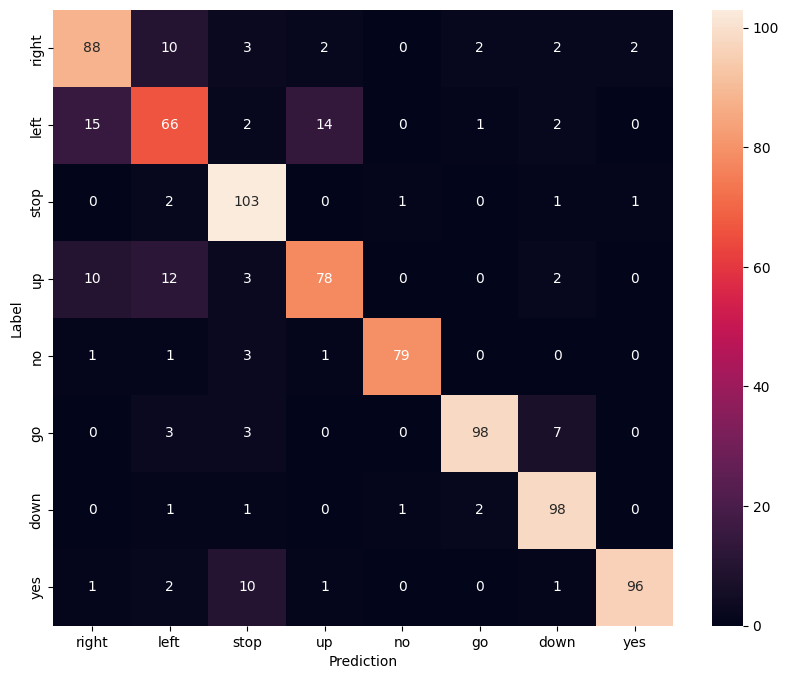

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## 오디오 파일에 대한 추론 실행하기

마지막으로, "no"라고 말하는 사람의 입력 오디오 파일을 사용하여 모델의 예측 출력을 확인합니다. 모델의 성능은 어느 정도인가요?

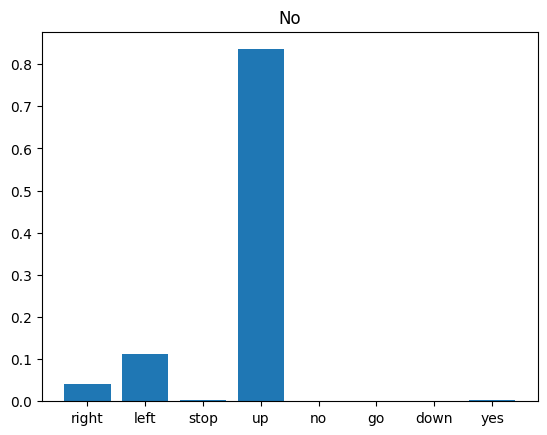

In [31]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

출력에서 알 수 있듯이 모델은 오디오 명령을 "no"로 인식해야 합니다.

## 전처리로 모델 내보내기

추론을 위해 데이터를 모델에 전달하기 전에 이러한 전처리 단계를 적용해야 하는 경우 모델을 사용하기가 쉽지 않습니다. 따라서 전체 버전을 빌드하세요.

In [32]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

"내보내기" 모델을 테스트 실행합니다.

In [33]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.0462228,  2.0565038, -1.2593   ,  4.0601997, -3.0643103,
         -2.2200623, -2.7304733, -1.2983409]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

모델을 저장하고 다시 로드하면 다시 로드된 모델이 동일한 출력을 제공합니다.

In [34]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.0462228,  2.0565038, -1.2593   ,  4.0601997, -3.0643103,
         -2.2200623, -2.7304733, -1.2983409]], dtype=float32)>}

## 다음 단계

이 튜토리얼에서는 TensorFlow 및 Python과 함께 콘볼루션 신경망을 사용하여 간단한 오디오 분류/자동 음성 인식을 수행하는 방법을 보여주었습니다. 자세히 알아보려면 다음 리소스를 살펴보세요.

- [YAMNet을 사용한 사운드 분류](https://www.tensorflow.org/hub/tutorials/yamnet) 튜토리얼 - 오디오 분류를 위해 전이 학습을 사용하는 방법을 보여줍니다.
- <a href="https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview" class="external">Kaggle의 TensorFlow 음성 인식 챌린지</a>에 기초한 노트북
- <a href="https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0" class="external">TensorFlow.js - 전이 학습 코드랩을 사용한 오디오 인식</a> - 오디오 분류를 위한 대화형 웹 앱을 직접 구축하는 방법을 알려줍니다.
- <a href="https://arxiv.org/abs/1709.04396" class="external">음악 정보 검색을 위한 딥 러닝 튜토리얼</a>(Choi 등, 2017) - arXiv에서 제공
- TensorFlow에서 [오디오 데이터 준비 및 확장](https://www.tensorflow.org/io/tutorials/audio)을 위한 추가 지원 제공 - 자체 오디오 기반 프로젝트를 쉽게 진행할 수 있습니다.
- 음악 및 오디오 분석을 위한 Python 패키지인 <a href="https://librosa.org/" class="external">librosa</a> 라이브러리 사용을 고려하세요.